In [ ]:
import OpenDVCW
import tensorflow as tf
from tensorflow.keras.models import Model

In [ ]:
model_dir = "/mnt/WindowsDev/PreTainedModels/OpenDVCW/HAAR200k/model_save_checkpoints_wavelets_haar_Lmbd_256_nfilt_256_epcs_5_stps_200000_I_QP_42_240x240_CosineDecay_20221207-161406/"
model = tf.keras.models.load_model(model_dir)

In [ ]:

i_frame = "/mnt/WindowsDev/DataSets/Beauty_1920x1080_120fps_420_8bit_YUV_RAW/im0.png"
p_frame = "/mnt/WindowsDev/DataSets/Beauty_1920x1080_120fps_420_8bit_YUV_RAW/im15.png"
comp_bin = "/workspaces/OpenDVCW/Test_com/tmp/tmp.bin"
recon_frame = "/workspaces/OpenDVCW/Test_com/tmp/recon.png"
motion_flow = "/workspaces/OpenDVCW/Test_com/tmp/flow.png"
width = 240
height = 240
channels = 3

Y0_com = OpenDVCW.read_png_crop(i_frame, width, height)
Y1_raw = OpenDVCW.read_png_crop(p_frame, width, height) 
Y0_com = tf.expand_dims(Y0_com, 0)
Y1_raw = tf.expand_dims(Y1_raw, 0)
Y0_com = tf.cast(Y0_com / 255, dtype=tf.float32)
Y1_raw = tf.cast(Y1_raw / 255, dtype=tf.float32)

In [ ]:
# OpenDVCW.compress(model, i_frame, p_frame, comp_bin, width, height)
# OpenDVCW.decompress(model, i_frame, comp_bin, recon_frame, width, height)
flow_tensor = model.get_weights()

In [ ]:
flow_tensor_c = flow_tensor[0, :240, :240, :] * 255
flow_tensor_u8 = tf.saturate_cast(tf.round(flow_tensor_c), tf.uint8)
OpenDVCW.write_png(motion_flow, flow_tensor_u8)

In [ ]:
print(tf.reduce_max(flow_tensor_c))

In [ ]:
flow_tensor

In [2]:
import matplotlib.pyplot as plt
import flyingchairs_data_loader
import cv2
import numpy as np
import time
import helpers




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


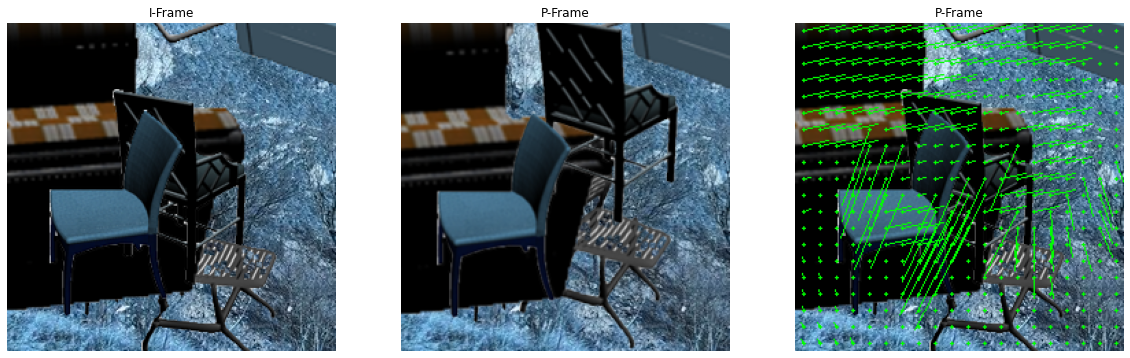

In [3]:

FLAGS = helpers.FlyingChairsFlags()
data_gen = flyingchairs_data_loader.DataLoader(FLAGS.data_dir, FLAGS.train_list, FLAGS.val_list)
train_dataset, val_dataset = data_gen.create_tf_dataset(FLAGS)
for im_pairs, flo_gt in train_dataset:
    im1 = im_pairs[0, :, :, :3]
    im2 = im_pairs[0, :, :, 3:]
    
    helpers.plot_ip_f(im1, im2, flo_gt[0])
    break


In [ ]:

example = list(train_dataset.as_numpy_iterator())

In [ ]:
example[0]